In [3]:
import torch
import os
import json
import tqdm
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection

# https://github.com/giannisnik/som/tree/master
# More popular but does not use any batching
# https://github.com/meder411/som-pytorch/tree/master
# Less popular but has implementation of batching from https://arxiv.org/abs/1811.06980
# But basically they sum up the deltas in each batch, but weight these depending on
# how frequent a node is the best matching unit

In [4]:
fnames = os.listdir("data")
fields = ['name','smiles','notes']
molecules = []
for fname in tqdm.tqdm(fnames):
    with open(os.path.join("data",fname)) as f:
        mol = json.load(f)
        data = {k:mol[k] for k in fields}
        # Check that the molecule has all the fields of interest
        if all(data.values()):
            molecules.append(data)

# Have to de-dupe the notes for each molecule.
for mol in molecules:
    mol["notes"] = set(mol["notes"])
    
print(f"Found {len(molecules)} molecules.")
molecules[:3]

100%|███████████████████████████████████| 19194/19194 [00:02<00:00, 6781.94it/s]

Found 3440 molecules.


[{'name': 'amyl butyrate',
  'smiles': 'CCCCCOC(=O)CCC',
  'notes': {'banana', 'cherry', 'fruity', 'pineapple', 'sweet', 'tropical'}},
 {'name': 'para-anisyl phenyl acetate',
  'smiles': 'COC1=CC=C(C=C1)COC(=O)CC2=CC=CC=C2',
  'notes': {'anise', 'balsamic', 'honey', 'woody'}},
 {'name': 'dihydrofarnesol',
  'smiles': 'CC(CC/C=C(\\C)/CCC=C(C)C)CCO',
  'notes': {'cyclamen', 'floral', 'metallic'}}]

In [5]:
all_notes = collections.Counter()
for mol in molecules:
    all_notes.update(mol["notes"])
print(f"Found {len(all_notes)} unique notes.")
print("Most common:")
print(all_notes.most_common(5))

Found 502 unique notes.
Most common:
[('fruity', 1060), ('green', 967), ('sweet', 884), ('floral', 706), ('woody', 558)]


In [6]:
all_notes_list = list(all_notes.keys())

def multi_hot(notes):
    indices = torch.tensor([all_notes_list.index(n) for n in notes])
    if len(indices) == 0:
        # Occurs when the notes in the pair were removed due to infrequency.
        raise AttributeError("Found no valid notes.")
    one_hots = torch.nn.functional.one_hot(indices, len(all_notes))
    return one_hots.sum(dim=0).float()

for mol in molecules:
    mol["encoding"] = multi_hot(mol["notes"])

print(molecules[0])

{'name': 'amyl butyrate', 'smiles': 'CCCCCOC(=O)CCC', 'notes': {'tropical', 'banana', 'pineapple', 'sweet', 'cherry', 'fruity'}, 'encoding': tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [7]:
SOM = collections.namedtuple("SOM",["vectors","idxs"])

def make_som(width,height):
    somap = torch.rand((width,height,len(all_notes)))

    map_x_idx, map_y_idx = torch.meshgrid(torch.arange(start=0,end=width), torch.arange(start=0,end=height), indexing='ij')
    map_idx = torch.stack([map_x_idx,map_y_idx],dim=-1)

    return SOM(somap,map_idx)


In [8]:
def get_activations(som,encoding):
    return torch.nn.functional.cosine_similarity(encoding, som.vectors, dim=-1)
    
def get_bmu(som,encoding):
    actvtn = get_activations(som,encoding)
    bmu_idx = (actvtn==torch.max(actvtn)).nonzero()
    return bmu_idx[0]

def get_score(som,encoding):
    actvtn = get_activations(som,encoding)
    return torch.max(actvtn)

def get_distances_manhattan(som,bmu):
    xy_dist = som.idxs - bmu
    return torch.sum(torch.abs(xy_dist),dim=-1)

def get_distances(som,bmu):
    xy_dist = som.idxs - bmu
    return torch.sqrt(torch.sum(torch.square(xy_dist),dim=-1))

def update_factor(som,bmu):
    dists = get_distances(som,bmu)
    return torch.pow(1/2,dists)

def update_factor_gauss(som,bmu,width):
    dists = get_distances(som,bmu)
    return torch.exp(torch.neg(torch.div(dists.square(), 2**width)))

def update_factor_with_negatives(som,bmu):
    dists = get_distances(som,bmu)
    dists = 1-2*(dists/dists.max())
    return dists.square()*dists.sign()

def get_deltas(som,encoding):
    return encoding-som.vectors

def update_som(som,encoding,lr):
    bmu = get_bmu(som,encoding)
    uf = update_factor(som,bmu)
    deltas = get_deltas(som,encoding)
    return SOM(som.vectors + lr*uf.unsqueeze(-1)*deltas, som.idxs)

mm = make_som(3,2)
print(mm.vectors.shape)
e0 = molecules[0]["encoding"]
bmu0 = get_bmu(mm,e0)
# When we do the update with lr=1, we expect the bmu to updated to the encoding
mp0 = update_som(mm,e0,1)
assert torch.all(mp0.vectors[bmu0[0],bmu0[1]] == e0)

torch.Size([3, 2, 502])


In [7]:
train_mols, test_mols = sklearn.model_selection.train_test_split(molecules)
# epochs = 1
# lr = 1e-1

def do_train(config,verbose=False):
    total_steps = config["epochs"]*len(train_mols)
    lrs = []
    scores = []

    som = make_som(config["width"],config["height"])
    
    def do_train_step(s):
        slr = config["lr"]*(1 - (s/total_steps))
        mol = random.choice(train_mols)
        return update_som(som,mol["encoding"],slr)
    
    def get_test_score():
        es = []
        for mol in test_mols:
            es.append(get_score(som,mol["encoding"]))
        return np.mean(es)

    try:
        for s in tqdm.tqdm(range(total_steps),smoothing=0, disable=not verbose):
            som = do_train_step(s)
            if s % 100 == 0:
                scores.append(get_test_score())
    except:
        print(f"Failed after {s}")
    return som, scores

 12%|█████▋                                       | 1/8 [00:00<00:03,  2.07it/s]

Config = {'width': 5, 'height': 4, 'epochs': 1, 'lr': 1}. Score = 0.40


 25%|███████████▎                                 | 2/8 [00:00<00:02,  2.07it/s]

Config = {'width': 5, 'height': 4, 'epochs': 1, 'lr': 0.1}. Score = 0.42


 38%|████████████████▉                            | 3/8 [00:05<00:12,  2.47s/it]

Config = {'width': 5, 'height': 4, 'epochs': 10, 'lr': 1}. Score = 0.41


 50%|██████████████████████▌                      | 4/8 [00:10<00:13,  3.42s/it]

Config = {'width': 5, 'height': 4, 'epochs': 10, 'lr': 0.1}. Score = 0.42


 62%|████████████████████████████▏                | 5/8 [00:19<00:15,  5.25s/it]

Config = {'width': 25, 'height': 20, 'epochs': 1, 'lr': 1}. Score = 0.57


 75%|█████████████████████████████████▊           | 6/8 [00:27<00:12,  6.33s/it]

Config = {'width': 25, 'height': 20, 'epochs': 1, 'lr': 0.1}. Score = 0.50


 88%|███████████████████████████████████████▍     | 7/8 [01:51<00:31, 31.73s/it]

Config = {'width': 25, 'height': 20, 'epochs': 10, 'lr': 1}. Score = 0.59


100%|█████████████████████████████████████████████| 8/8 [03:13<00:00, 24.22s/it]

Config = {'width': 25, 'height': 20, 'epochs': 10, 'lr': 0.1}. Score = 0.58


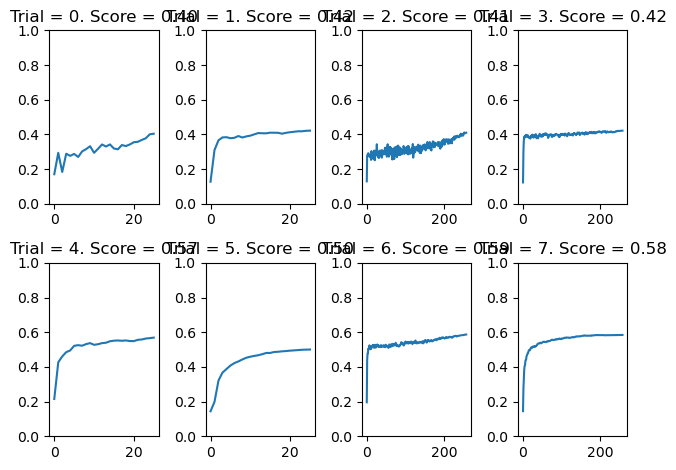

In [8]:
trials = [{"width":5,"height":4,"epochs":1,"lr":1},
          {"width":5,"height":4,"epochs":1,"lr":1e-1},
          {"width":5,"height":4,"epochs":10,"lr":1},
          {"width":5,"height":4,"epochs":10,"lr":1e-1},
          {"width":25,"height":20,"epochs":1,"lr":1},
          {"width":25,"height":20,"epochs":1,"lr":1e-1},
          {"width":25,"height":20,"epochs":10,"lr":1},
          {"width":25,"height":20,"epochs":10,"lr":1e-1}]

# trials = [{"width":5,"height":4,"epochs":1,"lr":1e-2},
#           {"width":5,"height":4,"epochs":1,"lr":5e-4},
#           {"width":5,"height":4,"epochs":10,"lr":1e-2},
#           {"width":5,"height":4,"epochs":10,"lr":5e-4},
#           {"width":25,"height":20,"epochs":1,"lr":1e-2},
#           {"width":25,"height":20,"epochs":1,"lr":5e-4},
#           {"width":25,"height":20,"epochs":10,"lr":1e-2},
#           {"width":25,"height":20,"epochs":10,"lr":5e-4}]

h = 4
fig, axs = plt.subplots(2,h)
for i, t in enumerate(tqdm.tqdm(trials)):
    _, scores = do_train(t)
    x = int(i/h)
    y = i%h
    ax = axs[x,y]
    ax.set_ylim(0, 1)
    ax.plot(scores)
    print(f"Config = {t}. Score = {scores[-1]:.2f}")
    ax.set_title(f"Trial = {i}. Score = {scores[-1]:.2f}")

fig.tight_layout()
plt.show()

In [24]:
som, scores = do_train({'width': 25*4, 'height': 20*4, 'epochs': 1, 'lr': 1},verbose=True)
# plt.set_ylim(0, 1)
plt.plot(scores)

100%|███████████████████████████████████████| 2580/2580 [02:33<00:00, 16.77it/s]


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_ylim'

tensor(0.) tensor(0.6589)


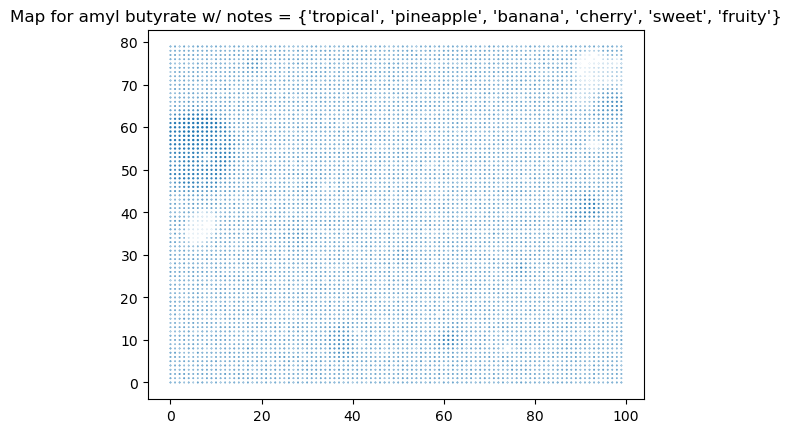

In [22]:
def flatten(mtrx):
    return mtrx.reshape((mtrx.shape[0]*mtrx.shape[1],-1)).squeeze()

pos = flatten(som.idxs).numpy()
act = flatten(get_activations(som,molecules[0]["encoding"]))
act = torch.nn.functional.threshold(act,1e-3,0)
print(act.min(),act.max())
plt.title(f"Map for {molecules[0]['name']} w/ notes = {molecules[0]['notes']}")
plt.scatter(pos[:,0],pos[:,1],s=act.numpy())
plt.show()

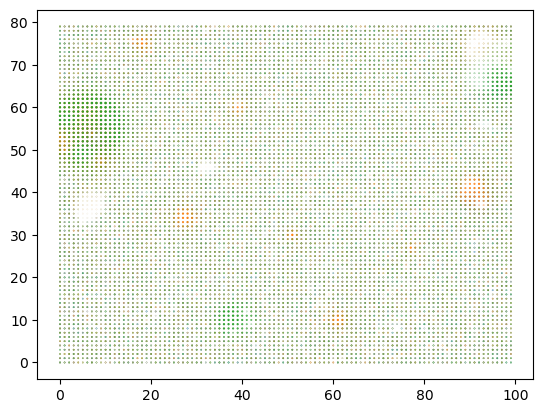

In [23]:

def clean_activations(activations,thresh):
    flact = flatten(activations)
    return torch.nn.functional.threshold(flact,thresh,0)

def plot(note):
    act = clean_activations(get_activations(som,multi_hot([note])),1e-4)
    plt.scatter(pos[:,0],pos[:,1],s=act.numpy())

plot("musk")
plot("sweet")
plot("fruity")
